# Special Activation Model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NN parameters
nn_name       = 'custom_activation_model'
batch_size    = 100
epochs        = 5
valid_split   = 0.3
input_window  = 10
output_window = 1
l2_reg        = 8e-6
opt_params    = [0.005, # learning rate
                 1e-7]  # epsilon

In [2]:
from src.utils import data_handler

#dataset = data_handler.load_csv('/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/direct_model.csv')
dataset = data_handler.load_csv('/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/forward_profiles.csv')

In [3]:
train_data, valid_data, time = data_handler.window_data(dataset=dataset,
                                                  input_labels=['pedal',
                                                                'velocity'],
                                                  output_labels=['acceleration'],
                                                  input_window=input_window,
                                                  output_window=output_window,
                                                  batch_size=batch_size,
                                                  validation_split=valid_split)

In [4]:
# Weights initializers
drag_init = np.ones(shape=(1, 1),
                    dtype=np.float32) # to make TF happy
fc_init   = np.ones(shape=(input_window, output_window),
                    dtype=np.float32)

weights_init = [drag_init,
                fc_init]

In [5]:
def activation_function_parameters():
    csvPath = '/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/forward_profiles.csv'
    myCsvData = np.genfromtxt(csvPath, dtype=np.float32, delimiter=',', skip_header=1)

    myVelocityArray = myCsvData[:, 2]

    maxVel = np.max(myVelocityArray)
    minVel = np.min(myVelocityArray)

    # How many triangles do I want?
    num_chan = 10

    # Array containing center of triangles superimposed on top of velocity range
    chan_arr = np.linspace(minVel, maxVel, num_chan)
    chan_arr = chan_arr.reshape(1, num_chan)

    channel_parameters = [num_chan, chan_arr]

    return channel_parameters

In [6]:
channel_parameters = activation_function_parameters()

In [7]:
import numpy as np
import tensorflow as tf
from src.functions import initializers as ci  # i.e., custom initalizers
from src.functions.layers import ActivLin1D  # import the custom activation function

# Disable eager execution so as not to get compilation errors using symbolic tensors
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


def activation_model(batch_size, input_shape, output_shape, weights_init, l2_reg, opt_params, channel_parameters):
    """
    Arguments:
     - batch_size:   size of the batch [int];
     - input_shape:  shape of the inputs;
     - output_shape: shape of the output;
     - weights_init: list of weight initializers;
     - l2_reg:       L2 regularization;
     - opt_params:   list of parameters for the optimizer [learning_rate, epsilon].
     - channel_parameters:   [num_chan , chan_array]
     - nn_layers: list of arrays that will contain number of NN large number of activation triangles we have and the initialization of the sum

    Outputs:
     - model: Keras NN model of the aforementioned scheme.
    """

    # -- INPUTS --
    # Input() is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor - like object, which we augment
    # with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.
    input_vx = tf.keras.layers.Input(shape=input_shape,
                                     batch_size=batch_size,
                                     name='input_vx')
    input_p = tf.keras.layers.Input(shape=input_shape,
                                    batch_size=batch_size,
                                    name='input_p')
    # Declare list of neural networks number large as size of activation functions
    neural_layer = [0.]*channel_parameters[0]
    # Final summed accelerations in output:
    neural_layer_out = 0.

    # -- INITIALIZERS --
    # Initializers define the way to set the initial random weights of Keras layers.
    drag_init = ci.MyInitializer(weights_init[0])
    fc_init = ci.MyInitializer(weights_init[1])

    # -- VELOCITY --
    # Square the input velocity :
    input_vx_squared = tf.keras.layers.Multiply(name='velocity_squared')([input_vx[:,-2:-1] , input_vx[:,-2:-1]])
    # Multiply by the weights:
    vel_weighted = tf.keras.layers.Dense(units=1,
                                         kernel_initializer='random_normal',
                                         use_bias=False,
                                         name='drag_coeff_layer')(input_vx_squared)
    # Negative ReLU:
    drag = -tf.keras.layers.ReLU(name='negative_ReLU')(vel_weighted)

    # -- PEDAL --
    # Loop through all the channels and add the activation that falls under the specific channel
    for i in range(channel_parameters[0]):
        custom_act_acc = ActivLin1D(chan_id=i,
                                    chan_arr=channel_parameters[1][0],
                                    name='activated_pedal_' + str(i) )([input_vx, input_p])
        neural_layer[i] = tf.keras.layers.Dense(units=1,
                                                kernel_initializer='random_normal',
                                                name='activated_neural_layer_' + str(i))(custom_act_acc)
    acceleration = tf.keras.layers.Add(name='neural_layer_out')(neural_layer)

    # -- SUM ACCELERATION AND DRAG --
    summed = tf.keras.layers.Add(name='acceleration_drag_final_sum')([acceleration , drag])

    # -- OUTPUT OF MODEL --
    output = summed

    # Define the model
    model = tf.keras.Model(inputs=[input_vx, input_p],
                           outputs=output,
                           name='custom_activation_model')

    # Optimizer parameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=opt_params[0],
                                         epsilon=opt_params[1])

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')

    return model

In [19]:
# Make the model
activated_model = activation_model( batch_size=batch_size,
                                    input_shape=input_window,
                                    output_shape=output_window,
                                    weights_init=weights_init,
                                    l2_reg=l2_reg,
                                    opt_params=opt_params,
                                    channel_parameters = activation_function_parameters())

Metal device set to: Apple M1


2023-01-26 17:02:49.961931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-26 17:02:49.962451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-26 17:02:49.969124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-26 17:02:49.975382: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-26 17:02:49.982530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:50.017089: I tensorflow/core/grappler/optimizers/custom_graph

In [20]:
activated_model.summary()

Model: "custom_activation_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_vx (InputLayer)          [(100, 10)]          0           []                               
                                                                                                  
 tf_op_layer_strided_slice (Ten  [(100, 1)]          0           ['input_vx[0][0]']               
 sorFlowOpLayer)                                                                                  
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(100, 1)]          0           ['input_vx[0][0]']               
 ensorFlowOpLayer)                                                                                
                                                                            

In [21]:
# Callbacks
save_path  = '/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/{nn_name}/{nn_name}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    verbose=1,
                                                    save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=100,
                                                  verbose=1)

In [22]:
# Fix the random seed for reproducibility
tf.keras.utils.set_random_seed(314159)

history = activated_model.fit(x=train_data[0],
                       y=train_data[1],
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       callbacks=[checkpoint,
                                  early_stop],
                       validation_data=valid_data,
                       shuffle=True,
                       use_multiprocessing=True)

Train on 12700 samples, validate on 5500 samples
Epoch 1/5


2023-01-26 17:02:54.142061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:54.170736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:54.332716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12500/12700 [============================>.] - ETA: 0s - loss: 0.0239

/Users/francescomaraschin/.conda/envs/Project_NN_Conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-01-26 17:02:58.114209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00627, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/custom_activation_model/custom_activation_model.h5
12700/12700 [==============================] - 5s 371us/sample - loss: 0.0235 - val_loss: 0.0063
Epoch 2/5
  500/12700 [>.............................] - ETA: 1s - loss: 0.0016

2023-01-26 17:02:58.746382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:58.750038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:58.753177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:58.760046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:58.766557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:58.771278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:02:58.776905: I tensorflow/core/grappler/optimizers/cust

12600/12700 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 2: val_loss did not improve from 0.00627
12700/12700 [==============================] - 2s 158us/sample - loss: 0.0019 - val_loss: 0.0063
Epoch 3/5
12600/12700 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 3: val_loss did not improve from 0.00627
12700/12700 [==============================] - 2s 151us/sample - loss: 0.0019 - val_loss: 0.0063
Epoch 4/5
12700/12700 [==============================] - ETA: 0s - loss: 0.0018
Epoch 4: val_loss did not improve from 0.00627
12700/12700 [==============================] - 2s 159us/sample - loss: 0.0018 - val_loss: 0.0063
Epoch 5/5
12300/12700 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 5: val_loss did not improve from 0.00627
12700/12700 [==============================] - 2s 157us/sample - loss: 0.0018 - val_loss: 0.0063


In [23]:
save_path="/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/custom_activation_model/custom_activation_model.h5"
best_model = tf.keras.models.load_model(filepath=save_path,
                                        custom_objects={
                                            'MyInitializer': ci.MyInitializer,
                                            'ActivLin1D': ActivLin1D,
                                            })

2023-01-26 17:03:10.591642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:03:10.608738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:03:10.625486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:03:10.732292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:03:10.775303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:03:10.801891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-26 17:03:10.864181: I tensorflow/core/grappler/optimizers/cust

/Users/francescomaraschin/.conda/envs/Project_NN_Conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-26 17:03:12.145471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


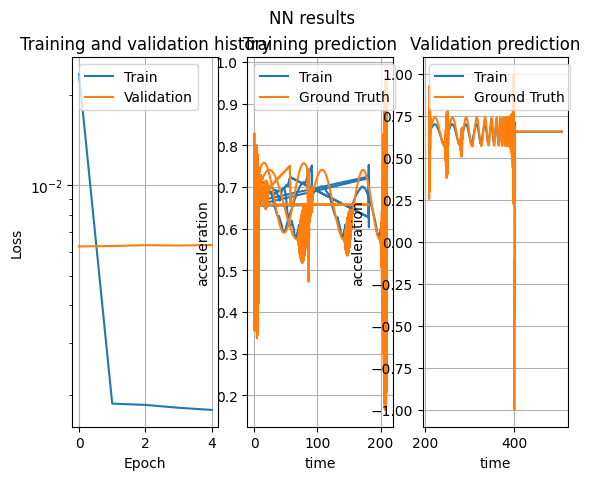

In [24]:
from src.utils import plotter

plotter.results(model=best_model,
               history=history,
               dataset=[train_data,
                        valid_data],
               time=time,
               batch_size=batch_size)

# Make dataset to do a prediction with the model:

In [25]:
# Make some data:

import numpy as np
import matplotlib.pyplot as plt

def linspace(start, stop, step=1.):
  """
    Like np.linspace but uses step instead of num
    This is inclusive to stop, so if start=1, stop=3, step=0.5
    Output is: array([1., 1.5, 2., 2.5, 3.])
  """
  return np.linspace(start, stop, int((stop - start) / step + 1))

time = linspace(0,100,step=0.05)
my_pedal = np.sin(time)
my_pedal = my_pedal
my_velocity = np.sin(time)
my_acceleration = np.cos(time)

import csv

header = ['', 'pedal', 'velocity','acceleration']
data = [time , my_pedal , my_velocity , my_acceleration]

%cd /Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv
with open('my_csv.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    for i in range(np.size(time)):
        writer.writerow([data[0][i] , data[1][i] , data[2][i] , data[3][i]])

/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv


<AxesSubplot: >

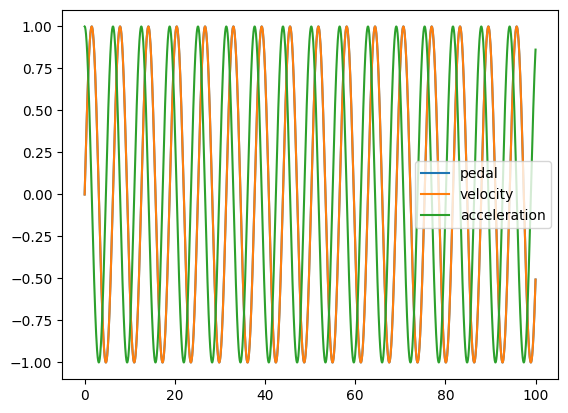

In [26]:
# Plot my data

csv_path = "/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/my_csv.csv"
my_data = data_handler.load_csv(csv_path)
my_data.plot()

In [27]:
# Window the data:

from src.utils.data_handler import window_data

my_train_data , my_valid_data , my_time = window_data(dataset=my_data,
                                                      input_labels=['pedal' , 'velocity'],
                                                      output_labels=['acceleration'],
                                                      input_window=10,
                                                      output_window=1,
                                                      batch_size=100,
                                                      validation_split=1)

In [28]:
# Predict with model:
# The predict function takes as an input the windowed data.

my_predictions = best_model.predict(my_valid_data[0])

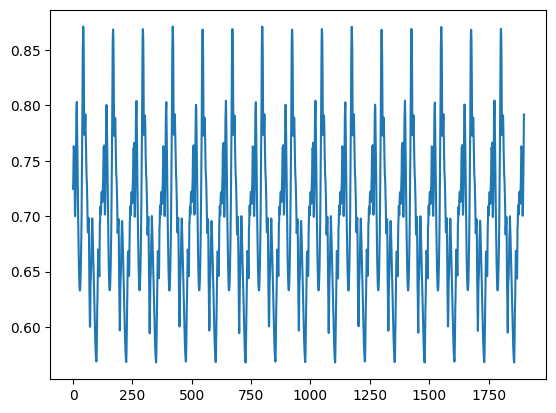

In [29]:
plt.plot( my_predictions  )

In [193]:
my_valid_data[1][0]

array([[ 1.        ],
       [ 1.        ],
       [ 1.        ],
       ...,
       [-0.84457684],
       [-0.8445233 ],
       [-0.8444697 ]], dtype=float32)

In [118]:
neural_layer = [0.]*10

In [124]:
neural_layer[]

IndexError: list index out of range

In [108]:
neural_layer[0][0]

IndexError: invalid index to scalar variable.

In [114]:
range(1,10)

range(1, 10)

In [2]:
import numpy as np
csvPath = "/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/direct_model.csv"
myCsvData = np.genfromtxt(csvPath, dtype=np.float32, delimiter=',', skip_header=1)

myVelocityArray = myCsvData[:, 2]

maxVel = np.max(myVelocityArray)
minVel = np.min(myVelocityArray)

# How many triangles do I want?
num_chan = 10

# Array containing center of triangles superimposed on top of velocity range
chan_arr = np.linspace(minVel, maxVel, num_chan)
chan_arr = chan_arr.reshape(1, num_chan)

channel_parameters = [num_chan, chan_arr]



In [3]:
channel_parameters

[10,
 array([[-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
          0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ]])]

In [13]:
s = np.linspace(0, 10, 10).reshape((1, 10))

In [14]:
s[0]

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])